## Step 1: Load the Preprocessed Dataset

We begin by loading the cleaned and scaled dataset, prepared during EDA.

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('../data/processed/cleaned_data.csv')
df.head()


,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache,prognosis
0,0.030303,1,0.729691,0.586755,0.264610,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,0.545455,0,0.654889,0.364238,0.486594,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,0.444444,0,0.515404,0.709272,0.136890,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,0.050505,0,0.933323,0.380132,0.575202,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,0.696970,0,0.593129,0.793377,0.572230,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


## Step 2: Convert Dataset to Transaction Format

We select binary symptom features and convert them into a format suitable for frequent pattern mining.

Frequent pattern mining algorithms like **FP-Growth** and **Apriori** expect data in a **transaction format**, where each item is either present (1/True) or absent (0/False). In our dataset, most symptom features are already binary, representing whether a patient experienced a specific symptom.

We exclude continuous features like `age`, `temperature`, `humidity`, and `wind_speed` because:
- They are not inherently transactional (e.g., 37°C is not an "item")
- They would need to be discretized into categories first
- Including them would reduce the interpretability and accuracy of the mined rules

By focusing only on binary features, we ensure that the itemsets discovered represent meaningful and interpretable **symptom co-occurrences**.


In [8]:
# Drop non-binary columns
exclude_cols = ['prognosis', 'Age', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Gender']
symptom_df = df.drop(columns=exclude_cols, errors='ignore')

print(f"Columns after dropping non-binary: {symptom_df.columns.tolist()}")

# Convert values to boolean (True/False) as required by mlxtend
symptom_df = symptom_df.astype(bool)

symptom_df.head()


Columns after dropping non-binary: ['nausea', 'joint_pain', 'abdominal_pain', 'high_fever', 'chills', 'fatigue', 'runny_nose', 'pain_behind_the_eyes', 'dizziness', 'headache', 'chest_pain', 'vomiting', 'cough', 'shivering', 'asthma_history', 'high_cholesterol', 'diabetes', 'obesity', 'hiv_aids', 'nasal_polyps', 'asthma', 'high_blood_pressure', 'severe_headache', 'weakness', 'trouble_seeing', 'fever', 'body_aches', 'sore_throat', 'sneezing', 'diarrhea', 'rapid_breathing', 'rapid_heart_rate', 'swollen_glands', 'rashes', 'sinus_headache', 'facial_pain', 'shortness_of_breath', 'reduced_smell_and_taste', 'skin_irritation', 'itchiness', 'throbbing_headache', 'confusion', 'back_pain', 'knee_ache']


,nausea,joint_pain,abdominal_pain,high_fever,chills,fatigue,runny_nose,pain_behind_the_eyes,dizziness,headache,...,sinus_headache,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache
0,True,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False


## Step 3: Run FP-Growth to Find Frequent Symptom Sets

We use the FP-Growth algorithm from `mlxtend` to find frequent combinations of symptoms.

### 🔍 What is FP-Growth?

FP-Growth (Frequent Pattern Growth) is an efficient and scalable algorithm used to find **frequent itemsets** in transactional data. Unlike the Apriori algorithm, which generates candidate itemsets and scans the dataset multiple times, FP-Growth builds a compact structure called an **FP-Tree** (Frequent Pattern Tree). This allows it to:

- Avoid generating unnecessary candidate combinations
- Reduce the number of full dataset scans
- Scale much better on larger datasets

### ✅ Why FP-Growth over Apriori?

We choose FP-Growth over Apriori for the following reasons:

- **Efficiency**: FP-Growth is faster and more memory-efficient, especially on datasets with many features or transactions.
- **Fewer scans**: It typically requires only two passes over the dataset, while Apriori may require many.
- **Better scalability**: FP-Growth handles moderate to large datasets more effectively.
- **Same output**: Both algorithms generate the same type of frequent itemsets, but FP-Growth gets there more efficiently.

For our dataset, which includes thousands of patient records and many binary symptom features, FP-Growth is the more practical choice.

### ℹ️ Choosing `min_support`

We set `min_support = 0.01` (1%) to include symptom patterns and diagnoses that are less common, but still medically relevant.

- Lower values allow us to find rules involving **rarer diseases**
- However, this increases the risk of including **weaker or less reliable rules**
- To mitigate this, we will later filter rules using **confidence and lift thresholds**

Given our dataset size (~5200 patients), 1% corresponds to at least 52 patients — a reasonable support level for exploratory pattern discovery. Also, this value allows to generate rules for each prognosis (diseases), in other words all the diseases are covered.



In [90]:
from mlxtend.frequent_patterns import fpgrowth

# Minimum support threshold (adjust if needed)
min_support = 0.01  # means 1% of all patients

frequent_itemsets = fpgrowth(symptom_df, min_support=min_support, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
12,0.261594,(hiv_aids)
20,0.240715,(headache)
19,0.207589,(vomiting)
13,0.168440,(chest_pain)
0,0.152981,(nausea)
14,0.139129,(high_blood_pressure)
92,0.139129,"(high_blood_pressure, chest_pain)"
93,0.133507,"(hiv_aids, high_blood_pressure)"
91,0.133507,"(hiv_aids, chest_pain)"
94,0.133507,"(hiv_aids, high_blood_pressure, chest_pain)"


## Step 4: Generate Association Rules

We generate rules in the form {symptom A, symptom B} → {symptom C}, and measure their confidence, lift, etc.

Each rule is evaluated using several metrics that help assess its strength, reliability, and usefulness.

### 🎯 Why Use `min_threshold = 0.6`?

In this step, we set `min_threshold = 0.6`, which means:
> Only rules with **confidence ≥ 60%** are included.

This ensures we focus on rules that are reasonably **reliable** — where the consequent (e.g., a disease) occurs in **at least 60% of cases** where the antecedent symptoms are present.

- Higher thresholds (e.g., 0.8) are **stricter** and may miss valid but weaker patterns.
- Lower thresholds (e.g., 0.3) may include **too many weak or noisy rules**.

So, 0.6 is a **balanced choice** — it captures meaningful associations without being overly restrictive.

---

### 📊 How to Interpret the Output Table

Each row in the table represents one association rule, with the following key metrics:

- **Antecedents**: The "if" part of the rule — a set of symptoms observed together.
- **Consequents**: The "then" part — another symptom or diagnosis that tends to follow.

#### Key Metrics:

| Metric              | Meaning                                                                 |
|---------------------|-------------------------------------------------------------------------|
| `support`           | Fraction of total records where both antecedent and consequent appear. |
| `confidence`        | How often the consequent appears when the antecedent is present.       |
| `lift`              | How much more likely the consequent is, given the antecedent, compared to random chance. |
| `leverage`          | The increase in probability of both items occurring together vs. by chance. |
| `conviction`        | How much more confident we are in the rule compared to its failure.    |
| `jaccard`           | Ratio of intersection to union of antecedent and consequent.           |
| `certainty` / `kulczynski` | Measures of balance and reliability for asymmetric relationships.        |

A **strong rule** typically has:
- High **confidence** (e.g., > 0.8)
- High **lift** (e.g., > 2)
- Reasonable **support** (to ensure it's not too rare)

These metrics help identify reliable patterns in patient symptoms and their relationship to disease outcomes.


In [91]:
from mlxtend.frequent_patterns import association_rules

min_threshold = 0.6  # Minimum confidence threshold

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_threshold)
rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
77,"(confusion, dizziness, nausea)",(rapid_heart_rate),0.015860,0.035736,0.010640,0.670886,18.773503,1.0,0.010074,2.929880,0.961991,0.259804,0.658689,0.484319
93,"(severe_headache, trouble_seeing)",(weakness),0.021281,0.036740,0.013652,0.641509,17.460975,1.0,0.012870,2.686990,0.963228,0.307692,0.627836,0.506547
69,"(confusion, nausea)",(rapid_heart_rate),0.024694,0.035736,0.015057,0.609756,17.062894,1.0,0.014175,2.470927,0.965228,0.331858,0.595294,0.515552
83,"(dizziness, high_fever)",(rapid_heart_rate),0.020679,0.035736,0.012447,0.601942,16.844224,1.0,0.011708,2.422420,0.960494,0.283105,0.587190,0.475128
63,(back_pain),(knee_ache),0.035535,0.038346,0.022285,0.627119,16.354335,1.0,0.020922,2.578982,0.973446,0.431907,0.612250,0.604135
91,(weakness),(trouble_seeing),0.036740,0.038145,0.022485,0.612022,16.044636,1.0,0.021084,2.479148,0.973438,0.429119,0.596636,0.600748
92,"(severe_headache, weakness)",(trouble_seeing),0.022686,0.038145,0.013652,0.601770,15.775873,1.0,0.012787,2.415325,0.958353,0.289362,0.585977,0.479832
39,"(dizziness, high_fever, nausea)",(confusion),0.012447,0.067055,0.010038,0.806452,12.026753,1.0,0.009203,4.820217,0.928408,0.144509,0.792540,0.478076
78,"(rapid_heart_rate, dizziness, nausea)",(confusion),0.013853,0.067055,0.010640,0.768116,11.455046,1.0,0.009712,4.023326,0.925523,0.151429,0.751449,0.463399
86,"(runny_nose, fever)",(sore_throat),0.018069,0.064445,0.012247,0.677778,10.517169,1.0,0.011082,2.903447,0.921569,0.174286,0.655582,0.433904


## Step 5: One-Hot Encode the `prognosis` Column

To discover association rules between symptoms and diagnoses, we one-hot encode the `prognosis` column and include it in the transactions.

In [92]:
# One-hot encode prognosis column
prognosis_ohe = pd.get_dummies(df['prognosis'], prefix='prognosis')

# Combine with symptom data
transactions_df = pd.concat([symptom_df, prognosis_ohe], axis=1)
transactions_df = transactions_df.astype(bool)

transactions_df.head()


,nausea,joint_pain,abdominal_pain,high_fever,chills,fatigue,runny_nose,pain_behind_the_eyes,dizziness,headache,...,prognosis_Common Cold,prognosis_Dengue,prognosis_Eczema,prognosis_Heart Attack,prognosis_Heat Stroke,prognosis_Influenza,prognosis_Malaria,prognosis_Migraine,prognosis_Sinusitis,prognosis_Stroke
0,True,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,True,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Step 6: Run FP-Growth with Prognosis Labels

We now rerun the FP-Growth algorithm on the expanded transaction set (symptoms + diagnosis labels).

In [93]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(transactions_df, min_support=min_support, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()


,support,itemsets
16,0.261594,(hiv_aids)
28,0.240715,(headache)
26,0.207589,(vomiting)
0,0.194338,(prognosis_Heart Attack)
27,0.180084,(prognosis_Migraine)


## Step 7: Generate Symptom-to-Diagnosis Rules

We generate association rules and filter for those where the **consequent is a disease** (i.e., `prognosis_X`).

In [94]:
from mlxtend.frequent_patterns import association_rules

# Generate rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)

# Define helper function: all consequents must be prognosis_X
def is_diagnosis_only(consequents):
    return all(str(item).startswith('prognosis_') for item in consequents)

# Apply strict filtering
disease_rules = rules[rules['consequents'].apply(is_diagnosis_only)]

#View unique prognosis labels
unique_prognoses = df['prognosis'].unique()
print(f"Unique prognosis labels: {unique_prognoses}")

# Extract all unique prognosis labels from disease_rules['consequents']
prognoses_in_rules = set()

for consequent in disease_rules['consequents']:
    for item in consequent:
        if str(item).startswith('prognosis_'):
            prognoses_in_rules.add(item.replace('prognosis_', ''))

# Print the sorted list
print("📋 Prognosis labels found in disease_rules:")
print(sorted(prognoses_in_rules))
print("-" * 50)

print(f"\nTotal number of diagnosis-related rules: {disease_rules.shape[0]}")
print("-" * 50)

# Extract only prognosis consequents
prognosis_counts = (
    disease_rules['consequents']
    .explode()  # separate each item in the set
    .astype(str)
    .loc[lambda x: x.str.startswith('prognosis_')]
    .str.replace('prognosis_', '', regex=False)
    .value_counts()
)

# Print results
print("\nNumber of rules per diagnosis:")
print(prognosis_counts)

# View top rules
disease_rules.sort_values(by='lift', ascending=False).head(10)



Unique prognosis labels: ['Heart Attack' 'Influenza' 'Dengue' 'Sinusitis' 'Eczema' 'Common Cold'
 'Heat Stroke' 'Migraine' 'Malaria' 'Arthritis' 'Stroke']
📋 Prognosis labels found in disease_rules:
['Arthritis', 'Common Cold', 'Dengue', 'Eczema', 'Heart Attack', 'Heat Stroke', 'Influenza', 'Malaria', 'Migraine', 'Sinusitis', 'Stroke']
--------------------------------------------------

Total number of diagnosis-related rules: 165
--------------------------------------------------

Number of rules per diagnosis:
consequents
Heart Attack    25
Heat Stroke     25
Migraine        19
Influenza       18
Sinusitis       16
Dengue          15
Malaria         14
Arthritis       13
Stroke          11
Common Cold      6
Eczema           3
Name: count, dtype: int64


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
43,"(runny_nose, sinus_headache)",(prognosis_Sinusitis),0.018671,0.06043,0.018671,1.0,16.548173,1.0,0.017543,inf,0.957447,0.308970,1.0,0.654485
41,"(runny_nose, sinus_headache, facial_pain)",(prognosis_Sinusitis),0.010038,0.06043,0.010038,1.0,16.548173,1.0,0.009432,inf,0.949098,0.166113,1.0,0.583056
38,"(sinus_headache, facial_pain)",(prognosis_Sinusitis),0.016262,0.06043,0.016262,1.0,16.548173,1.0,0.015279,inf,0.955102,0.269103,1.0,0.634551
36,(sinus_headache),(prognosis_Sinusitis),0.031118,0.06043,0.031118,1.0,16.548173,1.0,0.029238,inf,0.969747,0.514950,1.0,0.757475
34,"(runny_nose, facial_pain)",(prognosis_Sinusitis),0.022285,0.06043,0.022285,1.0,16.548173,1.0,0.020938,inf,0.960986,0.368771,1.0,0.684385
31,(facial_pain),(prognosis_Sinusitis),0.034933,0.06043,0.034933,1.0,16.548173,1.0,0.032822,inf,0.973580,0.578073,1.0,0.789037
46,"(sinus_headache, reduced_smell_and_taste)",(prognosis_Sinusitis),0.016061,0.06043,0.016061,1.0,16.548173,1.0,0.015090,inf,0.954907,0.265781,1.0,0.632890
47,(reduced_smell_and_taste),(prognosis_Sinusitis),0.033327,0.06043,0.033327,1.0,16.548173,1.0,0.031313,inf,0.971963,0.551495,1.0,0.775748
48,"(runny_nose, reduced_smell_and_taste)",(prognosis_Sinusitis),0.019876,0.06043,0.019876,1.0,16.548173,1.0,0.018674,inf,0.958624,0.328904,1.0,0.664452
468,"(nasal_polyps, reduced_smell_and_taste)",(prognosis_Sinusitis),0.012247,0.06043,0.012247,1.0,16.548173,1.0,0.011506,inf,0.951220,0.202658,1.0,0.601329


## Step 8: Visualize Symptom-to-Diagnosis Association Rules

We plot each rule using:
- X-axis: Confidence
- Y-axis: Lift
- Bubble size: Support
This helps us identify strong and reliable rules for diagnosing diseases.


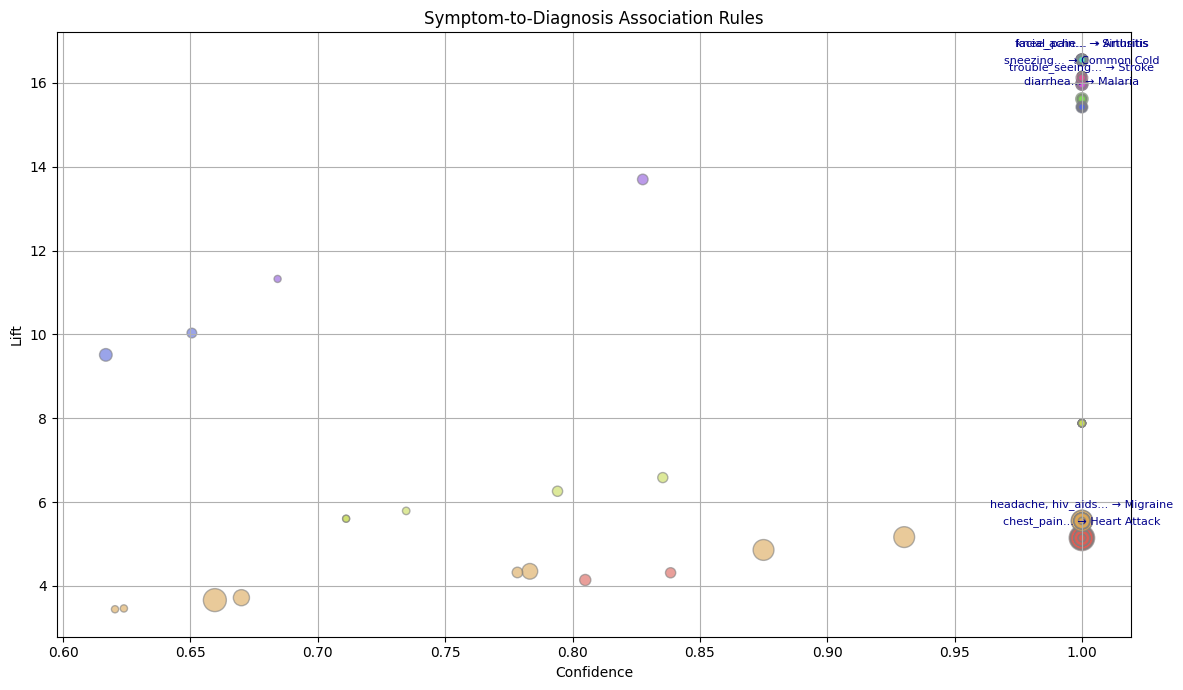

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Add label column with clean prognosis names
disease_rules = disease_rules.copy()
disease_rules['label'] = disease_rules['consequents'].apply(
    lambda x: ', '.join([i.replace('prognosis_', '') for i in x])
)

# Step 2: Assign colors for each unique diagnosis
colors = sns.color_palette('hls', n_colors=disease_rules['label'].nunique())
color_map = dict(zip(disease_rules['label'].unique(), colors))
rule_colors = disease_rules['label'].map(color_map)

# Step 3: Calculate a ranking score (e.g., lift * support) for diversity
disease_rules['score'] = disease_rules['lift'] * disease_rules['support']
top_rules = (
    disease_rules.sort_values(by='score', ascending=False)
    .drop_duplicates('label')  # one top rule per disease
    .head(7)
)

# Step 4: Create bubble plot
plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    disease_rules['confidence'],
    disease_rules['lift'],
    s=disease_rules['support'] * 2000,
    alpha=0.6,
    c=rule_colors,
    edgecolors='gray'
)

plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Symptom-to-Diagnosis Association Rules')
plt.grid(True)

# Step 5: Annotate top diverse rules
for _, row in top_rules.iterrows():
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents'])).replace('prognosis_', '')
    label = f"{antecedents[:25]}... → {consequents}"
    
    plt.annotate(
        label,
        (row['confidence'], row['lift']),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkblue'
    )

plt.tight_layout()
plt.show()


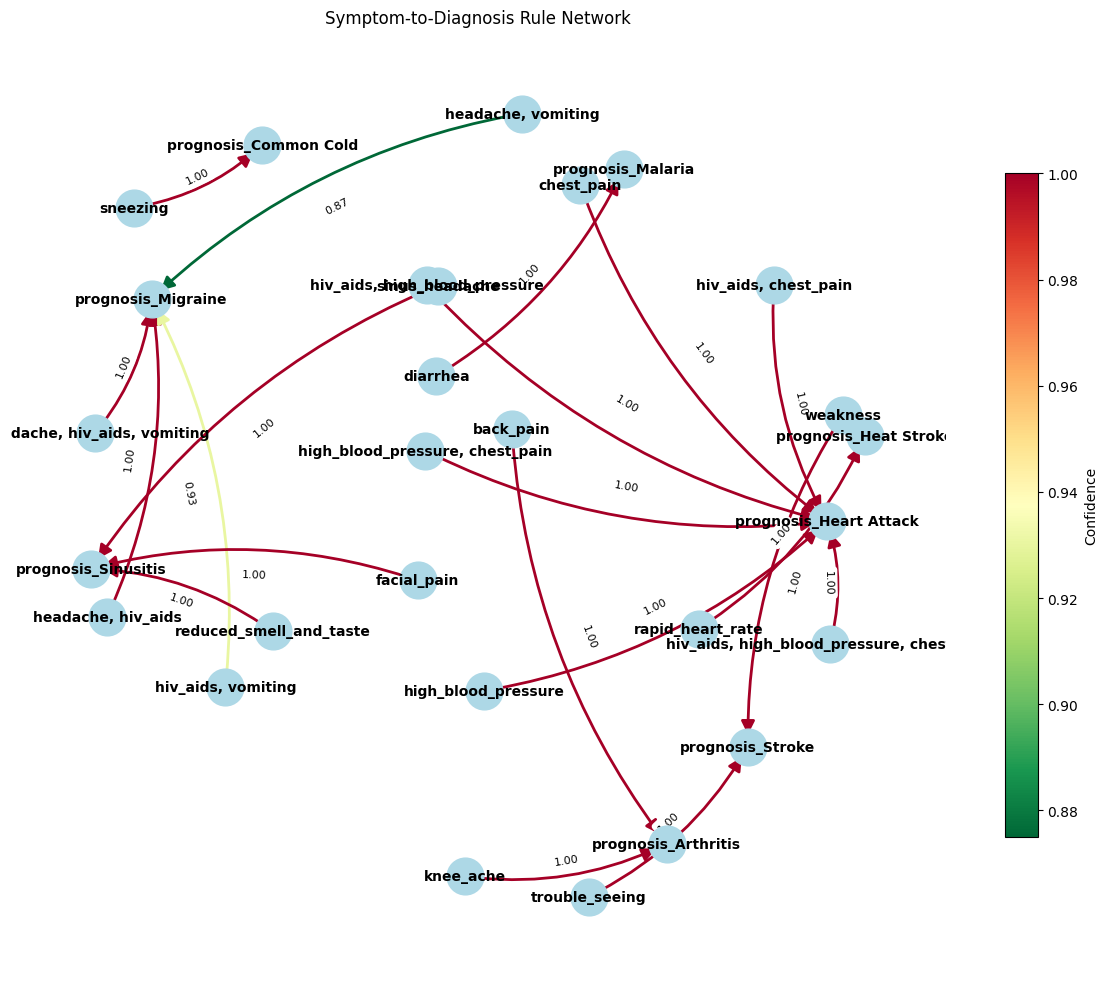

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Sort by score (lift * support) and pick top N
top_rules = disease_rules.copy()
top_rules['score'] = top_rules['lift'] * top_rules['support']
top_rules = top_rules.sort_values(by='score', ascending=False).head(20)  # pick top 10 rules

rules_subset = top_rules[['antecedents', 'consequents', 'confidence']]

# Initialize directed graph
G = nx.DiGraph()

# Map confidence to colors
confidences = rules_subset['confidence'].tolist()
min_conf, max_conf = min(confidences), max(confidences)
norm = mcolors.Normalize(vmin=min_conf, vmax=max_conf)
cmap = plt.get_cmap('RdYlGn_r')  # Red = low confidence, Green = high

# Add edges to graph with color encoding
for _, row in rules_subset.iterrows():
    antecedent = ', '.join(map(str, row['antecedents']))
    consequent = ', '.join(map(str, row['consequents']))
    confidence = row['confidence']
    color = cmap(norm(confidence))
    G.add_edge(antecedent, consequent, confidence=confidence, color=color)

# Setup layout
fig, ax = plt.subplots(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.9)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', ax=ax)

# Draw edges with confidence-based colors
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos, ax=ax, edge_color=edge_colors,
    arrows=True, arrowstyle='-|>', arrowsize=20, width=2,
    connectionstyle='arc3,rad=0.15'
)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
edge_labels = {(u, v): f"{G[u][v]['confidence']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

# Color bar for confidence
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Confidence')

plt.title('Symptom-to-Diagnosis Rule Network')
plt.axis('off')
plt.tight_layout()
plt.show()


In [130]:
from pyvis.network import Network
from IPython.display import display, HTML
import webbrowser
import os

# Prepare top rules for clarity
top_rules = disease_rules.copy()
top_rules['score'] = top_rules['lift'] * top_rules['support']
top_rules = top_rules.sort_values(by='score', ascending=False).head(30)
rules_subset = top_rules[['antecedents', 'consequents', 'confidence']]

# Initialize Pyvis network
net = Network(height="1000px", width="100%", directed=True, notebook=False, bgcolor='#ffffff', font_color='black')
net.barnes_hut(gravity=-25000, central_gravity=0.3, spring_length=200)

# Add nodes and edges
for _, row in rules_subset.iterrows():
    antecedents = ', '.join(map(str, row['antecedents']))
    consequents = ', '.join(map(str, row['consequents']))
    confidence = row['confidence']
    
    # Add nodes if not already added
    net.add_node(antecedents, label=antecedents, color='lightblue')
    net.add_node(consequents, label=consequents, color='orange')
    
    # Add edge with confidence as title
    net.add_edge(antecedents, consequents, title=f"Confidence: {confidence:.2f}")

# Save and show the network as HTML
output_path = "../report/diagnosis_rules_network.html"

# Open the graph in your default web browser
webbrowser.open('file://' + os.path.realpath(output_path))

True